In [2]:
import numpy as np
import qutip as qt 
from ECD_control.ECD_optimization.batch_optimizer import BatchOptimizer
from ECD_control.ECD_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


Need tf version 2.3.0 or later. Using tensorflow version: 2.3.1



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14947057504639224870, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6762656584921233309
 physical_device_desc: "device: XLA_CPU device"]

In [3]:
#The target oscillator state.
N =40
Fock = 3
psi_t = qt.basis(N,3) #target state

In [4]:
#Optimization of ECD Circuit parameters (betas, phis, and thetas)
#the optimization options
opt_params = {
'N_blocks' : 7, #circuit depth
'N_multistart' : 200, #Batch size (number of circuit optimizations to run in parallel)
'epochs' : 200, #number of epochs before termination
'epoch_size' : 10, #number of adam steps per epoch
'learning_rate' : 0.01, #adam learning rate
'term_fid' : 0.995, #terminal fidelitiy
'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
'beta_scale' : 3.0, #maximum |beta| for random initialization
'initial_states' : [qt.tensor(qt.basis(2,0),qt.basis(N,0))], #qubit tensor oscillator, start in |g> |0>
'target_states' : [qt.tensor(qt.basis(2,1), psi_t)], #end in |e> |target>.
'name' : 'Fock %d' % Fock, #name for printing and saving
'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}
#note: optimizer includes pi pulse in every ECD step. However, final ECD step is implemented 
#in experiment as a displacement since the qubit and oscillator should be disentangled at this point.
#So, we ask the optimizer to end in |e> |target> instead of |g>|target>.

In [5]:
#create optimization object. 
#initial params will be randomized upon creation
opt = BatchOptimizer(**opt_params)

#print optimization info. 
opt.print_info()

optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
use_displacements: False
name: Fock 3
comment: 
N_cav: 40
filename: Fock 3.h5

Best circuit parameters found:
betas:         [ 0.40323-0.24922j -1.09579-0.1292j  -2.3341 +1.2483j   0.83319-1.43553j
 -1.71962+0.71846j -0.84033-2.25499j  0.37796+0.32885j]
alphas:        [0.+0.j]
phis (deg):    [   0.       146.06093 -166.94373 -119.99116   53.41917  -68.74264
  -12.30728]
thetas (deg):  [  60.72564 -177.63362  -93.08402  115.37436  143.62163  -51.52764
  -38.37141]
Max Fidelity:  0.252059




In [6]:
#run optimizer.
opt.optimize()

Start time: 2021-11-13 20:11:02
 Epoch: 28 / 200 Max Fid: 0.996268 Avg Fid: 0.871756 Max dFid: 0.093604 Avg dFid: 0.002662 Elapsed time: 0:06:24.133708 Remaing time: 0:39:19.678491

 Optimization stopped. Term fidelity reached.

optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
use_displacements: False
name: Fock 3
comment: 
N_cav: 40
filename: Fock 3.h5

Best circuit parameters found:
betas:         [-1.00566-1.81694j  0.63691-0.67465j -1.05138+0.98401j -0.52507-1.19424j
  0.4937 -0.25014j -0.24625-0.27261j  0.00624+0.07266j]
alphas:        [0.+0.j]
phis (deg):    [   0.        87.96604   98.26064   74.55904  105.54572 -103.98199
   14.19465]
thetas (deg):  [ 89.7534  -27.03135  82.72486  60.5778  123.78381 -73.95439  89.64608]
Max Fidelity:  0.996490


all data saved as: Fock 3.h5
termination reason: term_fid
optimization timestamp (start tim

'2021-11-13 20:11:02'

In [7]:
#can print info, including the best circuit found.
opt.print_info() 

optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
use_displacements: False
name: Fock 3
comment: 
N_cav: 40
filename: Fock 3.h5

Best circuit parameters found:
betas:         [-1.00566-1.81694j  0.63691-0.67465j -1.05138+0.98401j -0.52507-1.19424j
  0.4937 -0.25014j -0.24625-0.27261j  0.00624+0.07266j]
alphas:        [0.+0.j]
phis (deg):    [   0.        87.96604   98.26064   74.55904  105.54572 -103.98199
   14.19465]
thetas (deg):  [ 89.7534  -27.03135  82.72486  60.5778  123.78381 -73.95439  89.64608]
Max Fidelity:  0.996490




In [8]:
#can also get the best circuit directly, could save this to a .npz file.
best_circuit =  opt.best_circuit()
print(best_circuit)

{'fidelity': 0.99648994, 'betas': array([-1.0056584 -1.8169438j ,  0.63691384-0.67465234j,
       -1.0513785 +0.98400617j, -0.5250722 -1.1942381j ,
        0.49369892-0.25014088j, -0.24624985-0.27261344j,
        0.00623842+0.07265711j], dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.        ,  1.5352972 ,  1.7149718 ,  1.3013008 ,  1.8421204 ,
       -1.8148282 ,  0.24774337], dtype=float32), 'thetas': array([ 1.5664923 , -0.47178602,  1.4438212 ,  1.0572822 ,  2.160435  ,
       -1.2907476 ,  1.5646193 ], dtype=float32)}


In [9]:
#Analysis of the results. Can load the .h5 file.
#all data is stored as a timestamp in a .h5 file
#You can also specify which timestamp you are analyzing. Be defult, it will use the most recent optimization in the file.
#I  recommend using "HDFview" software to understand data structure
#filename = opt.filename
filename = 'Fock %d.h5' % Fock
analysis = OptimizationAnalysis(filename)
analysis.print_info() #we can print info of best circuit

N_blocks: 7
N_cav: 40
N_multistart: 200
alpha_scale: 1.0
beta_scale: 3.0
comment: 
dfid_stop: 1e-06
elapsed_time_s: 384.1337077617645
epoch_size: 10
epochs: 200
learning_rate: 0.01
name: Fock 3
no_CD_end: False
optimization_type: state transfer
term_fid: 0.995
termination_reason: term_fid
use_displacements: False
filename: Fock 3.h5

Best circuit parameters found:
betas:         [-1.00566-1.81694j  0.63691-0.67465j -1.05138+0.98401j -0.52507-1.19424j
  0.4937 -0.25014j -0.24625-0.27261j  0.00624+0.07266j]
alphas:        [0.+0.j]
phis (deg):    [   0.        87.96604   98.26064   74.55904  105.54572 -103.98199
   14.19465]
thetas (deg):  [ 89.7534  -27.03135  82.72486  60.5778  123.78381 -73.95439  89.64608]
Max Fidelity:  0.996268




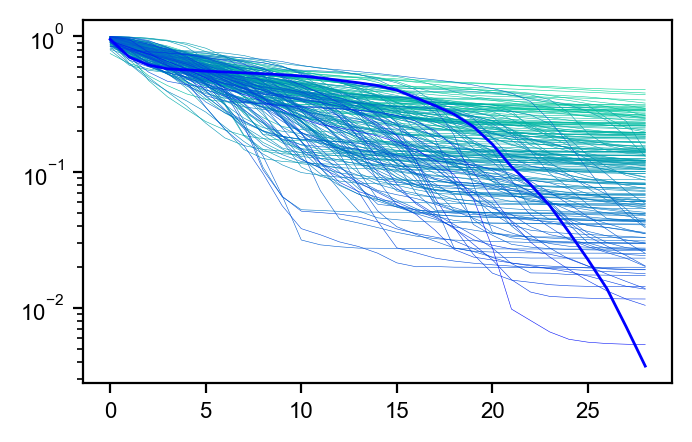

In [10]:
#We can plot the fidelities of the different parallel optimizations
analysis.plot_fidelities()

In [11]:
#We can also load the best circuit, states, and other parameters (see OptimizationAnalysis class)
best_circuit = analysis.best_circuit()
print(best_circuit)
target_state = analysis.target_state()
print(target_state)

{'fidelity': 0.9962677, 'betas': array([-1.0056584 -1.8169438j ,  0.63691384-0.67465234j,
       -1.0513785 +0.98400617j, -0.5250722 -1.1942381j ,
        0.49369892-0.25014088j, -0.24624985-0.27261344j,
        0.00623842+0.07265711j], dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.        ,  1.5352972 ,  1.7149718 ,  1.3013008 ,  1.8421204 ,
       -1.8148282 ,  0.24774337], dtype=float32), 'thetas': array([ 1.5664923 , -0.47178602,  1.4438212 ,  1.0572822 ,  2.160435  ,
       -1.2907476 ,  1.5646193 ], dtype=float32)}
Quantum object: dims = [[2, 40], [1, 1]], shape = (80, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0

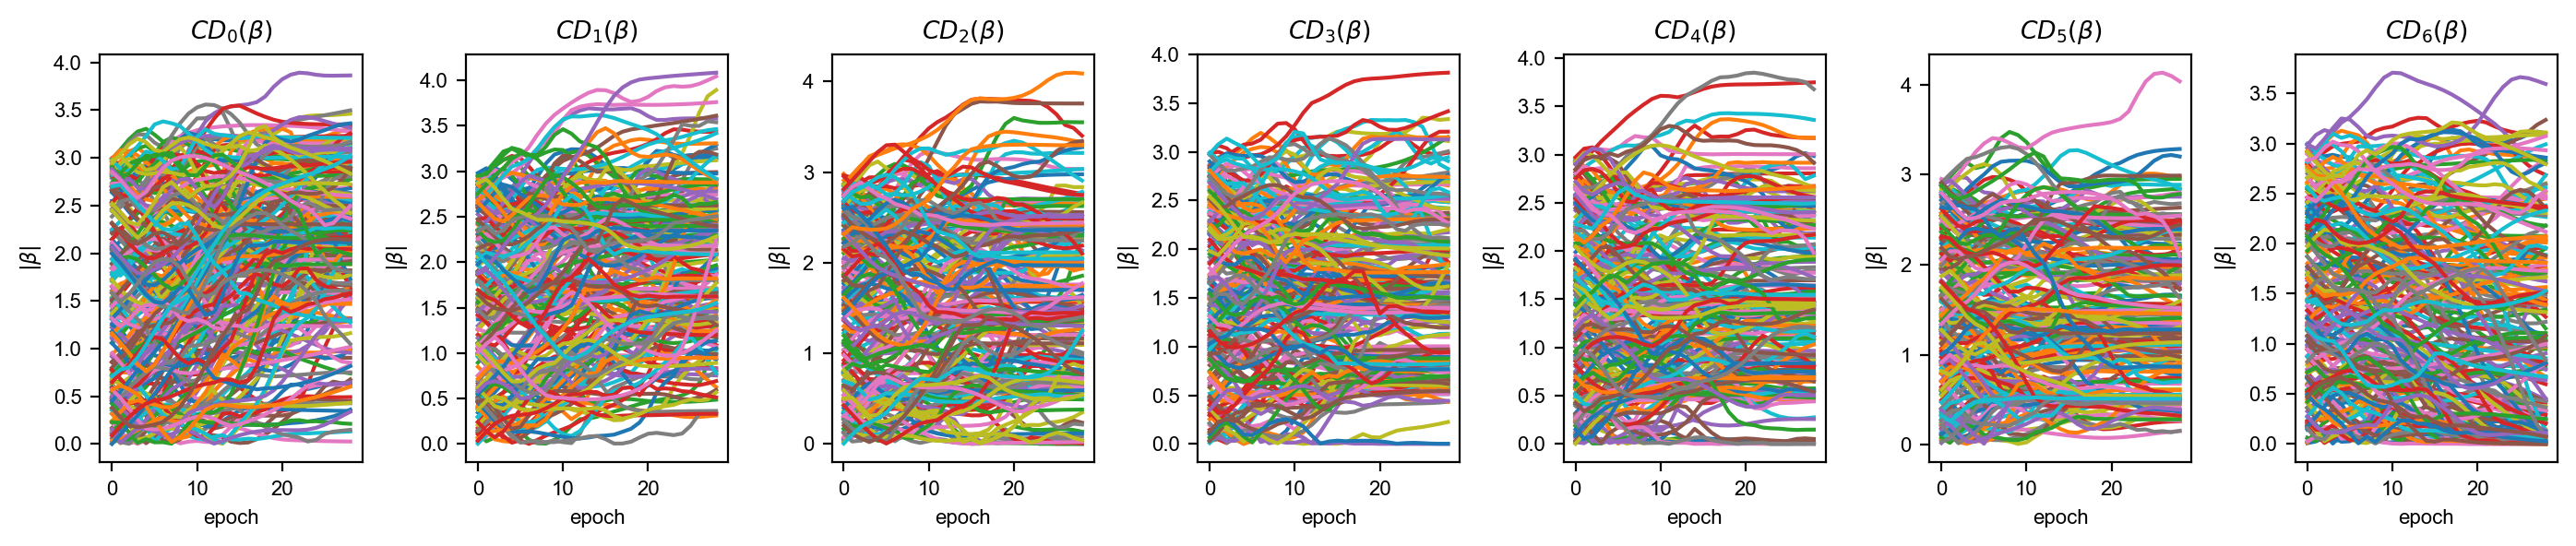

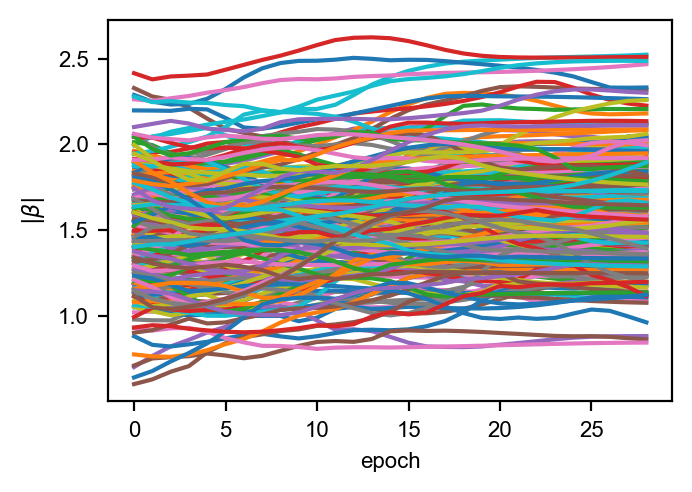

In [12]:
#there are a few other things we can plot.
analysis.plot_mag_betas()
analysis.plot_average_magnitude_beta()